## 1.Author 

**Student Name:** Karan Gadgil

**Student ID:** 200569103

## 2. Problem Formulation




Using the MLEnd Hums and Whistles dataset, implement a machine learning solution/pipeline to identify the voice label of input audio.  

## 3. Machine Learning pipeline 

**Import raw data:**

Data('hum' audio Audio files) of all songs mixed in '.wav' format. 

**Data Preparation:**


-Since we are not concerned with attributes such as the interpretation-type(hum/whistle) and song given the purpose of our machine learning pipeline (voice recognition), we have only taken the hum audio files for all the songs and extracted the 'participant_id'. 

-Thus we obtained a clean data frame consisting of columns viz. ('file_id','participant').

**Feature engineering (transform raw data into features):**


-The actual audio files in '.wav' format were imported with the help of python module - 'glob'

-Multiple audio features considered to be relevant for audio biometric upon reasearching listed ahead were extracted with our custom function 'getXY()'.
(power, pitch_mean,  pitch_std, voiced_fr, spectral_centroids, zero_crossings, spectral_rolloff, mfccs)


**Model selection:**

The below 2 models were tested for our dataset since we are dealing with a multiclass classification problem:

1)Support Vector Classifier 

2)The k-nearest neighbour 


**Prediction generation:**


A single audio file can be given as input to predict into our created model to detect the participant_id.


# 4. Transformation stage

-The input audio files are being transformed into a set of relevant audio features (power, pitch_mean,  pitch_std, voiced_fr, spectral_centroids, zero_crossings, spectral_rolloff, mfccs) using our custom 'getXy function'.

-This is being generated as a 2-D numpy array with 8 columns, each column corresponding to a particular feature.

-The 'Standard Scaler' will then receive the 2 dimensional array of features and it will scale it based on the mean and standard deviation of each feature.

# 5. Modelling 

The below 2 models have been considered for our dataset since we are dealing with a multiclass classification problem:

1)Support Vector Classifier : 

SVM (Support Vector Machine) classifies the data using hyperplane which acts like a decision boundary between different classes.It tries to find the best and optimal hyperplane which has maximum margin from each Support Vector. 
It is suitable for classification problems.

2)The k-nearest neighbour classifier :

kNN classifies an observation with the class that the majority of it's k neighbours belong to. Given a new observation(to be predicted) kNN model will calculate the distance to all the training samples.

# 6.Methodology

-The MLEnd H&W dataset is being split into 80% training data and 20% test data used for both training and validation respectively. 

-Due to data imbalance across various classes, we have used SMOTE oversampling technique and regenerated the X_train and y_train data.

-The performance of the model is assessed on the basis of it's traing accuracy, validation accuracy.

# 7. Dataset

-Since we are not concerned with attributes such as the interpretation-type(hum/whistle) and song given the purpose of our  machine learning pipeline (voice recognition). 

-As the pitch of whistle audio files can be misleading for the voice recognition problem, we have only taken the hum audio files for all the songs and extracted the 'participant_id' attribute.  

-Thus we obtained a clean data frame consisting of columns viz. ('file_id','participant') being used for further processing.

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm

import librosa

In [97]:
voice_hum_path = "E:\MSc Big Data Science\ML Mini Project Data set\hum_subset_voice_recognition\\*.wav"
voice_hum = glob.glob(voice_hum_path)
len(voice_hum)

135

In [99]:
MLENDHW_table = [] 
badFiles=[]
for file in voice_hum:
    song=""
    remove_brackets = re.sub(r"[[\]\(\)]", "", file)
    file_stripped=remove_brackets.split('.')[0].split("\\")[-1]
    file_name = file_stripped.split('\\')[-1]
    participant_ID = file_stripped.split('_')[0]
        
    digits=re.findall(r'\d+', file_name)
    interpretation_number = digits[-1]

    MLENDHW_table.append([file_name,participant_ID])

len(MLENDHW_table)


135

In [100]:
MLENDHW_table_1=np.array(MLENDHW_table)

MLENDHW_df = pd.DataFrame(MLENDHW_table_1,columns=['file_id','participant']).set_index('file_id') 
MLENDHW_df

,participant
file_id,
S10_hum_1_Hakuna,S10
S10_hum_1_Potter,S10
S10_hum_1_Rain,S10
S10_hum_2_Frozen,S10
S10_hum_2_Hakuna,S10
...,...
S9_hum_4_Frozen,S9
S9_hum_4_Panther,S9
S9_hum_4_Rain,S9


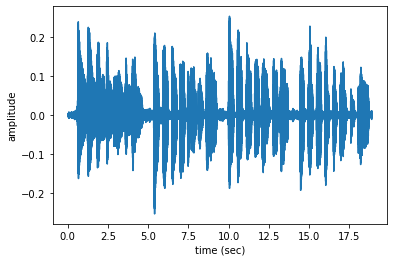

[Text(0.5, 1.0, 'Chromagram')]

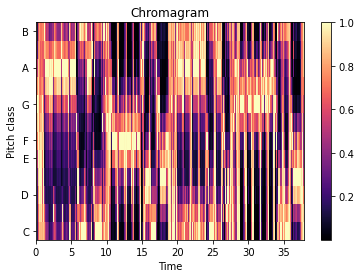

In [268]:
import librosa
n=10
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(voice_hum[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(voice_hum[n]))

# zero_crossings = librosa.zero_crossings(files[n], pad=False)
# print(zero_crossings)

spectral_centroids = librosa.feature.spectral_centroid(x,sr=fs)
spectral_centroids.shape

# zero_crossings = librosa.zero_crossings(x, pad=False)
# zero_crossings.shape

x, sr = librosa.load(voice_hum[n], duration=15)

import matplotlib.pyplot as plt
import librosa.display
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram')


In [101]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [103]:
import numpy as np
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    
    for file in tqdm(files): 
        
        remove_brackets = re.sub(r"[[\]\(\)]", "", file)
        file_stripped=remove_brackets.split('.')[0].split("\\")[-1]
        file_name = file_stripped.split('\\')[-1]
        file_id = file_stripped.split('\\')[-1]
        participant_ID = file_stripped.split('_')[0]
        yi=participant_ID
        
        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs)
        if scale_audio: x = x/np.max(np.abs(x))
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)
        
        spectral_centroids = librosa.feature.spectral_centroid(x,sr=fs)
        spectral_centroids=np.mean(spectral_centroids)

        zero_crossings = librosa.zero_crossings(x, pad=False)
        zero_crossings=np.mean(zero_crossings)

        spectral_rolloff = librosa.feature.spectral_rolloff(x,sr=fs)
        spectral_rolloff=np.mean(spectral_rolloff)

        mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=40)
        mfccs=np.mean(mfccs)

        xi = [power,pitch_mean,pitch_std,voiced_fr,spectral_centroids,zero_crossings,spectral_rolloff,mfccs]
        X.append(xi)     
        y.append(yi)

    return np.array(X),np.array(y)

In [104]:
X,y = getXy(voice_hum, labels_file=MLENDHW_df, scale_audio=True, onlySingleDigit=True)

100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [05:32<00:00,  2.47s/it]


In [193]:

# np.save("Advanced_feature_values",X)

print("count of label whistle:",np.unique(y))
print("count of label S1:",np.count_nonzero(y=='S1'))
print("count of label S2:",np.count_nonzero(y=='S2'))
print("count of label S3:",np.count_nonzero(y=='S3'))
print("count of label S4:",np.count_nonzero(y=='S4'))
print("count of label S5:",np.count_nonzero(y=='S5'))
print("count of label S6:",np.count_nonzero(y=='S6'))
print("count of label S7:",np.count_nonzero(y=='S7'))
print("count of label S8:",np.count_nonzero(y=='S8'))
print("count of label S9:",np.count_nonzero(y=='S9'))
print("count of label S10:",np.count_nonzero(y=='S10'))
print("count of label S141:",np.count_nonzero(y=='S141'))


In [165]:
#before standard scaling

print(X)

[[ 4.17295874e-02  1.79240748e+02  3.48472608e+01 ...  1.58873247e-02
   4.12021849e+03 -1.91865003e+00]
 [ 1.11072812e-02  1.29290113e+02  2.82635224e+01 ...  8.49585078e-03
   1.88820722e+03 -1.74463964e+00]
 [ 3.17245321e-02  1.36412991e+02  2.61310176e+01 ...  1.03739011e-02
   2.26198537e+03 -2.68908668e+00]
 ...
 [ 3.37670394e-02  1.56997218e+02  3.36356236e+01 ...  3.77913794e-02
   1.02413474e+04 -1.85496688e+00]
 [ 3.00883897e-02  1.63880310e+02  4.00266689e+01 ...  4.26619690e-02
   1.19846210e+04 -1.35327542e+00]
 [ 4.05616269e-02  1.61810649e+02  3.39227926e+01 ...  4.71389125e-02
   1.03776842e+04 -1.69618583e+00]]


In [166]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
scaler.mean_
X=scaler.transform(X)


In [167]:
#post standard scaling

print(X)

[[ 0.33540274 -0.60728338 -0.32542655 ... -1.18080363 -0.54303794
   1.26822242]
 [-1.42543143 -1.27259392 -0.83813564 ... -1.46884264 -1.24626483
   1.32649458]
 [-0.23990479 -1.17772174 -1.0042046  ... -1.39565673 -1.12850071
   1.01022059]
 ...
 [-0.12245717 -0.90355299 -0.41978288 ... -0.32722255  1.38551074
   1.28954847]
 [-0.33398573 -0.81187461  0.07792022 ... -0.1374201   1.93475389
   1.45755361]
 [ 0.26824304 -0.83944116 -0.39741957 ...  0.03704231  1.4284656
   1.34272066]]


# 8. Results

In [168]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((108, 8), (27, 8), (108,), (27,))

In [204]:
# model = svm.SVC(C=2)
# model.fit(X_train,y_train)

# yt_p = model.predict(X_train)
# yv_p = model.predict(X_val)

# print(yv_p)
# print('Training Accuracy', np.mean(yt_p==y_train))
# print('Validation Accuracy', np.mean(yv_p==y_val))
# print('The Support Vectors are', model.support_vectors_.shape)

# #normalising the training data
# mean = X_train.mean(0)
# sd = X_train.std(0)

# X_train_norm = (X_train-mean)/sd
# X_val_norm = (X_val-mean)/sd

#model trained using normalised x_train and x_val

model = svm.SVC(C=2)
model.fit(X_train_norm,y_train)

yt_p = model.predict(X_train_norm)
yv_p = model.predict(X_val_norm)

print(yv_p)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))
print('The Support Vectors are', model.support_vectors_.shape)


['S1' 'S1' 'S4' 'S5' 'S8' 'S3' 'S8' 'S4' 'S3' 'S5' 'S10' 'S7' 'S8' 'S2'
 'S8' 'S6' 'S5' 'S9' 'S8' 'S4' 'S4' 'S7' 'S9' 'S4' 'S141' 'S10' 'S9']
Training Accuracy 0.9722222222222222
Validation Accuracy 0.8888888888888888
The Support Vectors are (97, 8)


In [112]:
print("Before OverSampling, counts of label 'S1': {}".format(sum(y_train == 'S1')))
print("Before OverSampling, counts of label 'S2': {}".format(sum(y_train == 'S2')))
print("Before OverSampling, counts of label 'S3': {}".format(sum(y_train == 'S3')))
print("Before OverSampling, counts of label 'S4': {}".format(sum(y_train == 'S4')))
print("Before OverSampling, counts of label 'S5': {}".format(sum(y_train == 'S5')))
print("Before OverSampling, counts of label 'S6': {}".format(sum(y_train == 'S6')))
print("Before OverSampling, counts of label 'S7': {}".format(sum(y_train == 'S7')))
print("Before OverSampling, counts of label 'S8': {}".format(sum(y_train == 'S8')))
print("Before OverSampling, counts of label 'S9': {}".format(sum(y_train == 'S9')))
print("Before OverSampling, counts of label 'S10': {}".format(sum(y_train == 'S10')))
print("Before OverSampling, counts of label 'S41': {}".format(sum(y_train == 'S141')))


Before OverSampling, counts of label 'S1': 7
Before OverSampling, counts of label 'S2': 7
Before OverSampling, counts of label 'S3': 10
Before OverSampling, counts of label 'S4': 10
Before OverSampling, counts of label 'S5': 14
Before OverSampling, counts of label 'S6': 4
Before OverSampling, counts of label 'S7': 11
Before OverSampling, counts of label 'S8': 13
Before OverSampling, counts of label 'S9': 11
Before OverSampling, counts of label 'S10': 12
Before OverSampling, counts of label 'S41': 9


In [234]:
# We will attempt to rectify data imbalance observed above across classes using SMOTE technique 

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy='minority')
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=2, n_jobs=None)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


#normalising the samples generated through SMOTE

mean = X_train_res.mean(0)
sd = X_train_res.std(0)

X_train_res_norm = (X_train_res-mean)/sd

In [235]:
print("After OverSampling, counts of label 'S1': {}".format(sum(y_train_res == 'S1')))
print("After OverSampling, counts of label 'S2': {}".format(sum(y_train_res == 'S2')))
print("After OverSampling, counts of label 'S3': {}".format(sum(y_train_res == 'S3')))
print("After OverSampling, counts of label 'S4': {}".format(sum(y_train_res == 'S4')))
print("After OverSampling, counts of label 'S5': {}".format(sum(y_train_res == 'S5')))
print("After OverSampling, counts of label 'S6': {}".format(sum(y_train_res == 'S6')))
print("After OverSampling, counts of label 'S7': {}".format(sum(y_train_res == 'S7')))
print("After OverSampling, counts of label 'S8': {}".format(sum(y_train_res == 'S8')))
print("After OverSampling, counts of label 'S9': {}".format(sum(y_train_res == 'S9')))
print("After OverSampling, counts of label 'S10': {}".format(sum(y_train_res == 'S10')))
print("After OverSampling, counts of label 'S141': {}".format(sum(y_train_res == 'S141')))

After OverSampling, counts of label 'S1': 15
After OverSampling, counts of label 'S2': 15
After OverSampling, counts of label 'S3': 15
After OverSampling, counts of label 'S4': 15
After OverSampling, counts of label 'S5': 15
After OverSampling, counts of label 'S6': 15
After OverSampling, counts of label 'S7': 15
After OverSampling, counts of label 'S8': 15
After OverSampling, counts of label 'S9': 15
After OverSampling, counts of label 'S10': 15
After OverSampling, counts of label 'S141': 15


In [197]:
model = svm.SVC(C=2)
model.fit(X_train_res_norm,y_train_res)

yt_p = model.predict(X_train_res_norm)
yv_p = model.predict(X_val_norm)

print(yv_p)
print('Training Accuracy', np.mean(yt_p==y_train_res))
print('Validation Accuracy', np.mean(yv_p==y_val))
print('The Support Vectors are', model.support_vectors_.shape)

['S1' 'S1' 'S4' 'S5' 'S8' 'S3' 'S8' 'S4' 'S6' 'S5' 'S10' 'S7' 'S8' 'S2'
 'S8' 'S6' 'S5' 'S9' 'S8' 'S4' 'S4' 'S7' 'S9' 'S4' 'S141' 'S10' 'S9']
Training Accuracy 0.9878787878787879
Validation Accuracy 0.9259259259259259
The Support Vectors are (118, 8)


**We can see an increase in the validation accuracy post oversampling using SMOTE for SVC**

In [238]:
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors=6)
# knn.fit(X_train_res_norm, y_train_res)
knn1.fit(X_train_norm, y_train)

yt_knn_p = knn1.predict(X_train)
yv_knn_p = knn1.predict(X_val)

# print('Training Accuracy', np.mean(yt_p==y_train))
# print('Validation Accuracy', np.mean(yv_p==y_val))
# print('The Support Vectors are', model.support_vectors_.shape)

print('Training Accuracy', np.mean(yt_knn_p==y_train))
print('Validation Accuracy', np.mean(yv_knn_p==y_val))
print('The Support Vectors are', model.support_vectors_.shape)


# knn using oversampled data generated through SMOTE

knn2 = KNeighborsClassifier(n_neighbors=6)
# knn.fit(X_train_res_norm, y_train_res)
knn2.fit(X_train_res_norm, y_train_res)

yt_knn_p = knn2.predict(X_train_res_norm)
yv_knn_p = knn2.predict(X_val_norm)

# print('Training Accuracy', np.mean(yt_p==y_train))
# print('Validation Accuracy', np.mean(yv_p==y_val))
# print('The Support Vectors are', model.support_vectors_.shape)

print('Training Accuracy', np.mean(yt_knn_p==y_train_res))
print('Validation Accuracy', np.mean(yv_knn_p==y_val))
print('The Support Vectors are', model.support_vectors_.shape)

Training Accuracy 0.8055555555555556
Validation Accuracy 0.7407407407407407
The Support Vectors are (97, 8)
Training Accuracy 0.9030303030303031
Validation Accuracy 0.7407407407407407
The Support Vectors are (97, 8)


In [237]:
import warnings
warnings.filterwarnings("ignore")

# Using Naive Bayes for Classification
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb = gnb.fit(X_train_norm, y_train)

yt_p = gnb.predict(X_train_norm)
yv_p = gnb.predict(X_val_norm)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))


Training Accuracy 0.9537037037037037
Validation Accuracy 0.8518518518518519


In [218]:
def feature_extraction (file_path) :    
    single_input_file_path = file_path+'*.wav'
    single_file = glob.glob(single_input_file_path)
    print(single_file)
    
    single_file_predictor=[]
    for single in single_file:
            
            scale_audio=True
            onlySingleDigit=True
            remove_brackets = re.sub(r"[[\]\(\)]", "", single)
            file_stripped=remove_brackets.split('.')[0].split("\\")[-1]
            file_name = file_stripped.split('\\')[-1]
            file_id = file_stripped.split('\\')[-1]
            print(file_id)
            
            fs=None
            x, fs = librosa.load(single,sr=fs)
            if scale_audio: x = x/np.max(np.abs(x))
            f0, voiced_flag = getPitch(s,fs,winLen=0.02)
            
            power = np.sum(x**2)/len(x)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
            voiced_fr = np.mean(voiced_flag)
            
            spectral_centroids = librosa.feature.spectral_centroid(x,sr=fs)
            spectral_centroids=np.mean(spectral_centroids)
    
            zero_crossings = librosa.zero_crossings(x, pad=False)
            zero_crossings=np.mean(zero_crossings)
    
            spectral_rolloff = librosa.feature.spectral_rolloff(x,sr=fs)
            spectral_rolloff=np.mean(spectral_rolloff)
    
            mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=40)
            mfccs=np.mean(mfccs)
            
            xy = [power,pitch_mean,pitch_std,voiced_fr,spectral_centroids,zero_crossings,spectral_rolloff,mfccs]
        
            single_file_predictor.append(xy)
            
    return np.array(single_file_predictor)
    


In [219]:
features=feature_extraction('E:\\MSc Big Data Science\\ML Mini Project Data set\\test\\')

['E:\\MSc Big Data Science\\ML Mini Project Data set\\test\\harry_whistle.wav', 'E:\\MSc Big Data Science\\ML Mini Project Data set\\test\\S10_hum_4_Rain.wav', 'E:\\MSc Big Data Science\\ML Mini Project Data set\\test\\S10_hum_4_Showman.wav', 'E:\\MSc Big Data Science\\ML Mini Project Data set\\test\\S3_hum_4_Showman.wav', 'E:\\MSc Big Data Science\\ML Mini Project Data set\\test\\S3_hum_4_StarWars.wav', 'E:\\MSc Big Data Science\\ML Mini Project Data set\\test\\S4_hum_4_Frozen.wav', 'E:\\MSc Big Data Science\\ML Mini Project Data set\\test\\S4_hum_4_Panther.wav']
harry_whistle
S10_hum_4_Rain
S10_hum_4_Showman
S3_hum_4_Showman
S3_hum_4_StarWars
S4_hum_4_Frozen
S4_hum_4_Panther


In [224]:
#scaling the input file features before prediction
print(features)
scaler = StandardScaler()
scaler.fit(features)
scaler.mean_
features=scaler.transform(features)
print(features)


[[ 5.02985069e-02  3.92220872e+02  4.65008547e+01  7.11048159e-01
   1.49848123e+03  4.37293242e-02  1.99278506e+03 -6.14117765e+00]
 [ 3.69647611e-02  3.79758955e+02  4.53566994e+01  7.34655335e-01
   1.57764996e+03  1.54148982e-02  2.96312310e+03 -2.56264877e+00]
 [ 3.13181969e-02  3.79758955e+02  4.53566994e+01  7.34655335e-01
   2.03021784e+03  1.82952506e-02  4.20439855e+03 -1.99667418e+00]
 [ 2.01724263e-02  3.79758955e+02  4.53566994e+01  7.34655335e-01
   1.69441971e+03  3.69563850e-02  2.85889108e+03 -7.92105246e+00]
 [ 2.56723144e-02  3.79758955e+02  4.53566994e+01  7.34655335e-01
   1.58302681e+03  3.33259949e-02  2.82567602e+03 -7.50077677e+00]
 [ 4.16959159e-02  3.79758955e+02  4.53566994e+01  7.34655335e-01
   2.53013219e+03  8.20831252e-02  4.81412792e+03 -1.20691566e+01]
 [ 1.89893626e-02  3.79758955e+02  4.53566994e+01  7.34655335e-01
   3.12425516e+03  9.66205313e-02  6.39881827e+03 -1.12563324e+01]]
[[ 1.69365248  2.44948974  2.44948974 -2.44948974 -0.89564311 -0.100

In [264]:
which_class = model.predict(features)
print(which_class)


['S141' 'S10' 'S2' 'S3' 'S3' 'S8' 'S4']


**Findings/Observations:**

Tested models (SVC, KNN, GaussianNB) on our dataset.

-Across all 3 models, the accuracy seemed to increase tangibly post oversampling using SMOTE for SVC

-The best accuracy for training and validation was achieved for SVC model:

	Training Accuracy 0.987
    
	Validation Accuracy 0.925

# 9.Conclusions

We have been able to attain a good accuracy through our machine learning pipeline for SVC model compared to (KNN, GaussianNB) for our voice recognition problem.

**Future scope & improvements:** 

-The designed pipeline could achieve a better accuracy with more data since we have been restricted to under 16 samples per participant.

-Access to more attributes/labels related to our dataset would have enabled us to formulate and solve more diverse problems such as (gender prediction, emotion prediction etc).